In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!ls

best_model.h5  drive  sample_data


In [ ]:
!pip install hazm

In [ ]:
import pandas as pd
import re
from hazm import word_tokenize, Normalizer, stopwords_list
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/archive.zip', delimiter='\t',usecols=['comment', 'label_id'],on_bad_lines='skip')

In [ ]:
def preprocess(text):
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove usernames (@user)
    text = re.sub('@[^\s]+', '', text)
    # remove hashtags (#hashtag)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove non-Persian characters and punctuations
    text = re.sub(r'[^\u0600-\u06FF\uFB8A\u067E\u0686\u06AF\u200c]+', ' ', text)
    # normalize text
    normalizer = Normalizer()
    text = normalizer.normalize(text)
    # tokenize words
    words = word_tokenize(text)
    # remove Finglish words
    words = [w for w in words if not re.match(r'[a-zA-Z]+', w)]
    # join words into a string
    text = ' '.join(words)
    return text

df['comment'] = df['comment'].apply(preprocess)

In [ ]:
# Tokenize comments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'])

# Calculate the number of words
vocab_size = len(tokenizer.word_index) + 1

# Convert comments to sequences of integers and add padding
max_length = 100
X = tokenizer.texts_to_sequences(df['comment'])
X = pad_sequences(X, maxlen=max_length, padding='post')
y = df['label_id']

In [ ]:
# Split data into training, validation, and testing sets
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

In [ ]:
def get_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Reshape input data
X_train = X_train.reshape((X_train.shape[0], max_length, 1))
X_val = X_val.reshape((X_val.shape[0], max_length, 1))

In [8]:
model = get_model()
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val, verbose=0)
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/5
1750/1750 [==============================] - 410s 233ms/step - loss: nan - accuracy: 0.4989 - val_loss: nan - val_accuracy: 0.5003
Epoch 2/5
1750/1750 [==============================] - 407s 233ms/step - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5003
Epoch 3/5
1750/1750 [==============================] - 402s 230ms/step - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5003
Epoch 4/5
1750/1750 [==============================] - 399s 228ms/step - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5003
Epoch 5/5
1750/1750 [==============================] - 398s 228ms/step - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5003
Test Accuracy: 50.03%


In [98]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [107]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/archive.zip', delimiter='\t',usecols=['comment', 'label_id'],on_bad_lines='skip')

In [114]:
data.dropna(inplace=True)

In [115]:
data['label_id'] = data['label_id'].astype(int)

In [116]:
X = (data['comment'])
y = (data['label_id'])

In [117]:
X 

0          واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1        قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...
2        قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...
3        عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4                            شیرینی وانیلی فقط یک مدل بود.
                               ...                        
69995    سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...
69996    سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...
69997    من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...
69998    همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...
69999                               فلفلش خییییلی تند بود.
Name: comment, Length: 69480, dtype: object

In [118]:
y

0        1
1        0
2        1
3        0
4        0
        ..
69995    1
69996    1
69997    0
69998    1
69999    0
Name: label_id, Length: 69480, dtype: int64

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [120]:
vectorizer1 = TfidfVectorizer()
X = vectorizer1.fit_transform(X_train)

In [121]:
X_test = vectorizer1.transform(X_test)

<Axes: >

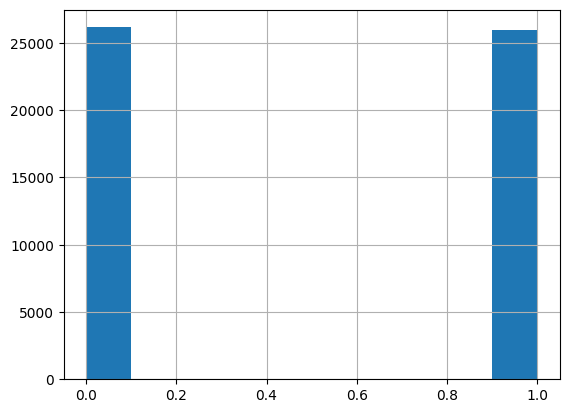

In [122]:
y_train.hist()

In [123]:
np.unique(y_train , return_counts=True)

(array([0, 1]), array([26165, 25945]))

In [124]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X, y_train.ravel())

In [127]:
np.unique(y_train_res , return_counts=True)

(array([0, 1]), array([26165, 26165]))

In [128]:
xgb = XGBClassifier()
xgb.fit(X_train_res , y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [129]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      8751
           1       0.80      0.91      0.85      8619

    accuracy                           0.84     17370
   macro avg       0.85      0.84      0.84     17370
weighted avg       0.85      0.84      0.84     17370

